# Conformal Experiment: Increase Confidence OvA

In [1]:
import json

import numpy as np
import torch
import matplotlib.pyplot as plt

from scipy import stats

In [2]:
n_classes = 10
random_expert_idx = 0
n_experts = 4

In [3]:
# === OvA ===
confs = []
exps = []
true = []
path = "ova_increase_confidence/"

p_experts = [0.2, 0.4, 0.6, 0.8, 0.95]
for p in p_experts:
    model_name = '_' + str(p) + '_confidence'
    with open(path + 'confidence_multiple_experts' + model_name + '.txt', 'r') as f:
        conf = json.loads(json.load(f))
    with open(path + 'expert_predictions_multiple_experts' + model_name + '.txt', 'r') as f:
        exp_pred = json.loads(json.load(f))
    with open(path + 'true_label_multiple_experts' + model_name + '.txt', 'r') as f:
        true_label = json.loads(json.load(f))
    true.append(true_label['test'])
    exps.append(exp_pred['test'])
    c = torch.tensor(conf['test'])
    # DANI Correction ===
    c = c.sigmoid()
    # DANI Correction ===
    confs.append(c)

### Check dimensions

In [249]:
# 1 expert rando, 3 with prob 0.95 correct
probs = confs[-3]
experts = exps[-3]
experts = experts[::-1]  # reverse order!
y_true = true[-3]

In [250]:
print("Probs: {}".format(probs[:5,10:]))

Probs: tensor([[0.6533, 0.6647, 0.6956, 0.1037],
        [0.2466, 0.3078, 0.2993, 0.1002],
        [0.2995, 0.3285, 0.3267, 0.0939],
        [0.5820, 0.6227, 0.6141, 0.0865],
        [0.3601, 0.3305, 0.3627, 0.1000]])


In [251]:
print("Experts: \n{}".format(np.array(experts)))

Experts: 
[[8 8 8 ... 2 4 5]
 [4 8 4 ... 9 3 5]
 [3 5 3 ... 9 2 5]
 [6 6 0 ... 7 2 7]]


In [177]:
print("Y True: \n{}".format(y_true[:5]))

Y True: 
[3, 8, 8, 0, 6]


In [178]:
n_val = int(0.8 * len(y_true))
n_test = len(y_true) - n_val
print("N val:{}".format(n_val))
print("N test:{}".format(n_test))

N val:7372
N test:1844


# Conformal Q_hat Calculation

In [179]:
def get_q_hat(a):
    
    
    
    
    
    
    

SyntaxError: unexpected EOF while parsing (3206550942.py, line 8)

In [180]:

n_classes_exp = n_classes + n_experts
probs_val = probs[:n_val, 10:]
experts_val = experts
experts_val = [exp[:n_val] for exp in experts_val]

y_true_val = y_true[:n_val]

# === Only on deferred samples
_, predicted = torch.max(probs[:n_val].data, 1)
r = (predicted >= n_classes_exp - n_experts)

# Filter 
probs_val = probs_val[r]
experts_val = [np.array(exp)[r] for exp in experts_val]
y_true_val = np.array(y_true_val)[r]

# Model expert probs ===
# Sort J model outputs for experts
probs_experts = probs[:n_val, 10:]
probs_experts = probs_experts[r]
sort, pi = probs_experts.sort(dim=1, descending=True)

# Correctness experts ===
# Check if experts are correct 
correct_exp = (np.array(experts_val) == np.array(y_true_val)).T
# idx for correct experts: [[0,1,2], [1,2], [], ...]
correct_exp_idx = [np.where(correct_exp_i)[0] for correct_exp_i in correct_exp]

# obtain the last expert to be retrieved. If empty, then add all values.
# indexes are not the real expert index, but the sorted indexes, e.g. [[1, 0 ,2],  [1,0], [], ...]
pi_corr_exp = [probs_experts[i, corr_exp].sort(descending=True)[1] for i, corr_exp in enumerate(correct_exp)]
pi_corr_exp_stop = [pi_corr_exp_i[-1] if len(pi_corr_exp_i)!=0 else -1 for pi_corr_exp_i in pi_corr_exp]  # last expert

# obtain real expert index back, e.g. [2,1,-1,...]
pi_stop = [correct_exp_idx[i][pi_corr_exp_stop_i] if len(correct_exp_idx[i])!=0 else -1 for i, pi_corr_exp_stop_i in enumerate(pi_corr_exp_stop)]


# =========
n_val = n_val
alpha = 0.1
scores = sort.cumsum(dim=1).gather(1, pi.argsort(1))[range(len(torch.tensor(pi_stop))), torch.tensor(pi_stop)]
qhat = torch.quantile(scores, np.ceil((r.sum() + 1) * (1 - alpha)) / r.sum(), interpolation="higher")

qhat

tensor(1.9849)

# Test

In [181]:
probs_test = probs[n_val:, n_classes:]
experts_test = [exp[n_val:] for exp in experts]
y_true_test = y_true[n_val:]

In [182]:
# === Only on deferred samples
_, predicted = torch.max(probs[n_val:].data, 1)
r_test = (predicted >= n_classes_exp - n_experts)

# Filter 
probs_test = probs_test[r_test]
experts_test = [np.array(exp)[r_test] for exp in experts_test]
y_true_test = np.array(y_true_test)[r_test]

# Sort J model outputs for experts. sorted probs and sorted indexes
sort_test, pi_test = probs_test.sort(dim=1, descending=True)
# Get last sorted index to be below Q_hat
pi_stop = (sort_test.cumsum(dim=1) <= qhat).sum(axis=1)

# Prediction sets
prediction_sets = [(pi_test[i][:(pi_stop[i])]).numpy() for i in range(pi_stop.shape[0])]  # not allow empty sets
prediction_sets[:5]

[array([2, 1, 0]),
 array([2, 0, 1, 3]),
 array([2, 1, 0, 3]),
 array([2, 1, 0, 3]),
 array([2, 1, 0, 3])]

<AxesSubplot:ylabel='Count'>

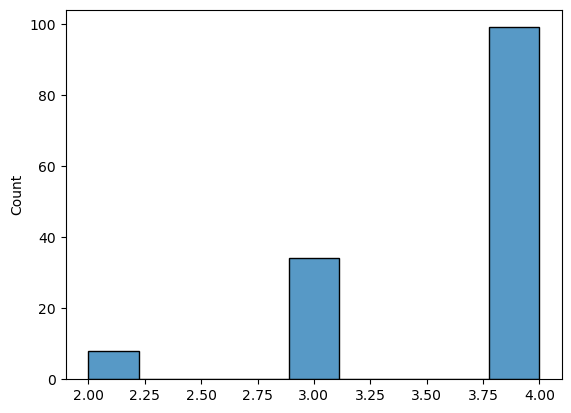

In [183]:
a = np.array([len(prediction_sets_i) for prediction_sets_i in prediction_sets])
import seaborn as sns

sns.histplot(a)

# Metrics Computation

### Accuracy w/o Conformal on deferred samples

In [293]:
correct = 0
correct_sys = 0
exp = 0
exp_total = 0
total = 0
real_total = 0
alone_correct = 0
#  === Individual Expert Accuracies === #
expert_correct_dic = {k: 0 for k in range(len(experts_test))}
expert_total_dic = {k: 0 for k in range(len(experts_test))}

In [294]:
# 1 expert rando, 3 with prob 0.9 correct
probs = confs[-1]
experts = exps[-1]
experts = experts[::-1] 
y_true = true[-1]

In [295]:
n_classes = 10
n_experts = 4
n_classes_exp = n_classes + n_experts

probs_test = probs[n_val:]
experts_test = [exp[n_val:] for exp in experts]
y_true_test = y_true[n_val:]


In [296]:
# Predicted value 
_, predicted = torch.max(probs_test.data, 1)
# Classifier alone prediction
_, prediction = torch.max(probs_test.data[:, :(n_classes_exp - n_experts)],1)

### w Conformal Prediction

In [297]:
def get_expert_prediction(experts, prediction_set_i, method="voting"):
    ensemble_expert_pred_i = np.array(experts_test)[prediction_set_i][:, i]
    if method == "voting":
        exp_prediction = stats.mode(ensemble_expert_pred_i).mode
        
    if method == "last": 
        exp_prediction = ensemble_expert_pred_i[-1]
        
    if method == "random":
        exp_prediction = ensemble_expert_pred_i[np.random.randint(len(ensemble_expert_pred_i))] 
        
    return exp_prediction

In [298]:
method="last"

In [299]:
labels = y_true_test

# Predicted value 
_, predicted = torch.max(probs_test.data, 1)
# Classifier alone prediction
_, prediction = torch.max(probs_test.data[:, :(n_classes_exp - n_experts)],1)

for i in range(0, n_test):
    r = (predicted[i].item() >= n_classes_exp - len(experts_test))
    alone_correct += (prediction[i] == labels[i]).item()
    
    # Non-deferred 
    if r == 0:
        total += 1
        correct += (predicted[i] == labels[i]).item()
        correct_sys += (predicted[i] == labels[i]).item()
        
    # Deferred 
    if r == 1:
        # Conformal prediction ===        
        # Sort J model outputs for experts. sorted probs and sorted indexes
        sort_i, pi_i = probs_test[i,n_classes:].sort(descending=True)
        # Get last sorted index to be below Q_hat
        pi_stop_i = (sort_i.cumsum(dim=0) <= qhat).sum()

        # Prediction sets
        prediction_set_i = (pi_i[:(pi_stop_i)]).numpy()  # not allow empty sets        
        
        
        
        # - Get expert prediction depending on method
        # ======
        exp_prediction = get_expert_prediction(experts_test, prediction_set_i, method=method)
        # ======
        
        
        
        # Deferral accuracy: No matter expert ===
        exp += (exp_prediction == labels[i])
        exp_total += 1
        # Individual Expert Accuracy ===
        # expert_correct_dic[deferred_exp] += (exp_prediction == labels[i].item())
        # expert_total_dic[deferred_exp] += 1
        #
        correct_sys += (exp_prediction == labels[i])
    real_total += 1



#  ===  Coverage  === #    
cov = str(total) + str(" out of") + str(real_total)

#  === Individual Expert Accuracies === #
expert_accuracies = {"expert_{}".format(str(k)): 100 * expert_correct_dic[k] / (expert_total_dic[k] + 0.0002) for k
             in range(len(experts_test))}
# Add expert accuracies dict
to_print = {"coverage": cov,
            "system_accuracy": 100 * correct_sys / real_total,
            "expert_accuracy": 100 * exp / (exp_total + 0.0002),
            "classifier_accuracy": 100 * correct / (total + 0.0001),
            "alone_classifier": 100 * alone_correct / real_total}
print(to_print, flush=True)


{'coverage': '1485 out of1844', 'system_accuracy': 85.24945770065077, 'expert_accuracy': 52.92476160180412, 'classifier_accuracy': 93.06396679703927, 'alone_classifier': 86.22559652928416}


In [300]:
print("Cov: {}".format(100 * (total/real_total)))

Cov: 80.53145336225597


In [301]:
expert_accuracies

{'expert_0': 0.0, 'expert_1': 0.0, 'expert_2': 0.0, 'expert_3': 0.0}

In [302]:
100 * exp / (exp_total + 0.0002),

(52.92476160180412,)

In [240]:
exp_total

359

In [197]:
100 * correct_sys / real_total

85.24945770065077

### w/o Conformal Prediction

In [198]:
correct = 0
correct_sys = 0
exp = 0
exp_total = 0
total = 0
real_total = 0
alone_correct = 0
#  === Individual Expert Accuracies === #
expert_correct_dic = {k: 0 for k in range(len(experts_test))}
expert_total_dic = {k: 0 for k in range(len(experts_test))}

In [199]:
# 1 expert rando, 3 with prob 0.9 correct
probs = confs[-3]
experts = exps[-3]
experts = experts[::-1] 
y_true = true[-3]

In [200]:
n_classes = 10
n_experts = 4
n_classes_exp = n_classes + n_experts

probs_test = probs[n_val:]
experts_test = [exp[n_val:] for exp in experts]
y_true_test = y_true[n_val:]


In [201]:
# Predicted value 
_, predicted = torch.max(probs_test.data, 1)
# Classifier alone prediction
_, prediction = torch.max(probs_test.data[:, :(n_classes_exp - n_experts)],1)

In [202]:
labels = y_true_test

# Predicted value 
_, predicted = torch.max(probs_test.data, 1)
# Classifier alone prediction
_, prediction = torch.max(probs_test.data[:, :(n_classes_exp - n_experts)],1)
for i in range(0, n_test):
    r = (predicted[i].item() >= n_classes_exp - len(experts_test))
    alone_correct += (prediction[i] == labels[i]).item()
    if r == 0:
        total += 1
        correct += (predicted[i] == labels[i]).item()
        correct_sys += (predicted[i] == labels[i]).item()
        
    if r == 1:
        deferred_exp = (predicted[i] - n_classes).item()  # reverse order, as in loss function
        # deferred_exp = ((n_classes - 1) - predicted[i]).item()  # reverse order, as in loss function
        exp_prediction = experts_test[deferred_exp][i]
        #
        # Deferral accuracy: No matter expert ===
        exp += (exp_prediction == labels[i])
        exp_total += 1
        # Individual Expert Accuracy ===
        expert_correct_dic[deferred_exp] += (exp_prediction == labels[i])
        expert_total_dic[deferred_exp] += 1
        #
        correct_sys += (exp_prediction == labels[i])
    real_total += 1
    
#  ===  Coverage  === #    
cov = str(total) + str(" out of") + str(real_total)

#  === Individual Expert Accuracies === #
expert_accuracies = {"expert_{}".format(str(k)): 100 * expert_correct_dic[k] / (expert_total_dic[k] + 0.0002) for k
             in range(len(experts_test))}






In [204]:
print("Cov: {}".format(100 * (total/real_total)))

Cov: 92.353579175705


In [205]:
expert_accuracies

{'expert_0': 0.0,
 'expert_1': 36.36297521863239,
 'expert_2': 59.230678106649066,
 'expert_3': 0.0}

In [206]:
100 * exp / (exp_total + 0.0002),

(57.44672702591911,)

In [207]:
exp

81

In [208]:
100 * correct_sys / real_total

88.1236442516269

# Metric Calculation

In [290]:
def get_expert_prediction(experts, prediction_set_i, method="voting"):
    ensemble_expert_pred_i = np.array(experts_test)[prediction_set_i][:, i]
    if method == "voting":
        exp_prediction = stats.mode(ensemble_expert_pred_i).mode
        
    if method == "last": 
        exp_prediction = ensemble_expert_pred_i[-1]
        
    if method == "random":
        exp_prediction = ensemble_expert_pred_i[np.random.randint(len(ensemble_expert_pred_i))] 
        
    return exp_prediction

In [291]:
dict.fromkeys(["last", "random", "voting"])

{'last': None, 'random': None, 'voting': None}

In [306]:
# Method dict ===
method_list = ["last", "random", "voting"]
method_dict = {"last": [],
               "random": [],
               "voting": []}


p_experts = [0.2, 0.4, 0.6, 0.8, 0.95]
alpha = 0.1
n_classes = 10
n_experts = 4
n_classes_exp = n_classes + n_experts

for method in method_list:
    
    print("Method: {}\n".format(method))
    for i, p_exp in enumerate(p_experts):
        # =============
        # = Get Probs =
        # =============

        probs = confs[i]
        experts = exps[i]
        experts = experts[::-1]  # reverse order!
        y_true = true[-i]

        # Val/Calibration ===
        probs_val = probs[:n_val, n_classes:]
        experts_val = [exp[:n_val] for exp in experts]
        y_true_val = y_true[:n_val]

        # Test ===
        probs_test = probs[n_val:, n_classes:]
        experts_test = [exp[n_val:] for exp in experts]
        y_true_test = y_true[n_val:]


        # =============
        # = Conformal =
        # =============

        # Calculate Q_hat ===

        # === Only on deferred samples
        _, predicted = torch.max(probs[:n_val].data, 1)
        r = (predicted >= n_classes_exp - n_experts)

        # Filter 
        probs_experts = probs_val[r]
        experts_val = [np.array(exp)[r] for exp in experts_val]
        y_true_val = np.array(y_true_val)[r]

        # Model expert probs ===
        # Sort J model outputs for experts
        sort, pi = probs_experts.sort(dim=1, descending=True)

        # Correctness experts ===
        # Check if experts are correct 
        correct_exp = (np.array(experts_val) == np.array(y_true_val)).T
        # idx for correct experts: [[0,1,2], [1,2], [], ...]
        correct_exp_idx = [np.where(correct_exp_i)[0] for correct_exp_i in correct_exp]

        # obtain the last expert to be retrieved. If empty, then add all values.
        # indexes are not the real expert index, but the sorted indexes, e.g. [[1, 0 ,2],  [1,0], [], ...]
        pi_corr_exp = [probs_experts[i, corr_exp].sort(descending=True)[1] for i, corr_exp in enumerate(correct_exp)]
        pi_corr_exp_stop = [pi_corr_exp_i[-1] if len(pi_corr_exp_i)!=0 else -1 for pi_corr_exp_i in pi_corr_exp]  # last expert

        # obtain real expert index back, e.g. [2,1,-1,...]
        pi_stop = [correct_exp_idx[i][pi_corr_exp_stop_i] if len(correct_exp_idx[i])!=0 else -1 for i, pi_corr_exp_stop_i in enumerate(pi_corr_exp_stop)]

        scores = sort.cumsum(dim=1).gather(1, pi.argsort(1))[range(len(torch.tensor(pi_stop))), torch.tensor(pi_stop)]
        n_quantile = r.sum()
        qhat = torch.quantile(scores, np.ceil((n_quantile + 1) * (1 - alpha)) / n_quantile, interpolation="higher")

        print("Q_hat {}: {}".format(p_exp, qhat))


        # =============
        # = Metrics =
        # =============

        # === Initalize ====

        correct = 0
        correct_sys = 0
        exp = 0
        exp_total = 0
        total = 0
        real_total = 0
        alone_correct = 0

        # Individual Expert Accuracies === #
        expert_correct_dic = {k: 0 for k in range(len(experts_test))}
        expert_total_dic = {k: 0 for k in range(len(experts_test))}

        probs_test_exp = probs_test
        probs_test_model = probs[n_val:]

        # Predicted value 
        _, predicted = torch.max(probs_test_model.data, 1)

        # Classifier alone prediction
        _, prediction = torch.max(probs_test_model.data[:, :(n_classes_exp - n_experts)],1)

        labels = y_true_test
        for i in range(0, n_test):
            r = (predicted[i].item() >= n_classes_exp - n_experts)
            alone_correct += (prediction[i] == labels[i]).item()

            # Non-deferred 
            if r == 0:
                total += 1
                correct += (predicted[i] == labels[i]).item()
                correct_sys += (predicted[i] == labels[i]).item()

            # Deferred 
            if r == 1:
                # Conformal prediction ===        
                # Sort J model outputs for experts. sorted probs and sorted indexes
                sort_i, pi_i = probs_test_exp[i].sort(descending=True)
                # Get last sorted index to be below Q_hat
                pi_stop_i = (sort_i.cumsum(dim=0) <= qhat).sum()

                # Prediction sets
                prediction_set_i = (pi_i[:(pi_stop_i)]).numpy()  # not allow empty sets        



                # - Get expert prediction depending on method
                # ======
                exp_prediction = get_expert_prediction(experts_test, prediction_set_i, method=method)
                # ======



                # Deferral accuracy: No matter expert ===
                exp += (exp_prediction == labels[i])
                exp_total += 1
                # Individual Expert Accuracy ===
                # expert_correct_dic[deferred_exp] += (exp_prediction == labels[i].item())
                # expert_total_dic[deferred_exp] += 1
                #
                correct_sys += (exp_prediction == labels[i])

            real_total += 1

        #  ===  Coverage  === #    
        cov = str(total) + str(" out of") + str(real_total)

        #  === Individual Expert Accuracies === #
        expert_accuracies = {"expert_{}".format(str(k)): 100 * expert_correct_dic[k] / (expert_total_dic[k] + 0.0002) for k
                     in range(len(experts_test))}

        # Add expert accuracies dict
        to_print = {"coverage": cov,
                    "system_accuracy": 100 * correct_sys / real_total,
                    "expert_accuracy": 100 * exp / (exp_total + 0.0002),
                    "classifier_accuracy": 100 * correct / (total + 0.0001),
                    "alone_classifier": 100 * alone_correct / real_total}
        print(to_print, flush=True)

        # Save to method dict === 
        method_dict[method].append(to_print)



Method: last

Q_hat 0.2: 0.9704249501228333
{'coverage': '1815 out of1844', 'system_accuracy': 83.78524945770064, 'expert_accuracy': 31.03426872918118, 'classifier_accuracy': 84.62809451084878, 'alone_classifier': 83.6767895878525}
Q_hat 0.4: 1.4368531703948975
{'coverage': '1784 out of1844', 'system_accuracy': 85.19522776572668, 'expert_accuracy': 24.999916666944443, 'classifier_accuracy': 87.21972605270594, 'alone_classifier': 85.68329718004338}
Q_hat 0.6: 1.9848847389221191
{'coverage': '1703 out of1844', 'system_accuracy': 85.35791757049891, 'expert_accuracy': 21.276565565155227, 'classifier_accuracy': 90.66352961459016, 'alone_classifier': 86.49674620390455}
Q_hat 0.8: 2.4831812381744385
{'coverage': '1649 out of1844', 'system_accuracy': 85.03253796095444, 'expert_accuracy': 32.82047915848291, 'classifier_accuracy': 91.20678646411241, 'alone_classifier': 86.44251626898048}
Q_hat 0.95: 2.8904409408569336
{'coverage': '1485 out of1844', 'system_accuracy': 85.24945770065077, 'expert_

In [288]:
method_dict

{'last': [{'coverage': '1815 out of1844',
   'system_accuracy': 83.78524945770064,
   'expert_accuracy': 31.03426872918118,
   'classifier_accuracy': 84.62809451084878,
   'alone_classifier': 83.6767895878525},
  {'coverage': '1784 out of1844',
   'system_accuracy': 85.19522776572668,
   'expert_accuracy': 24.999916666944443,
   'classifier_accuracy': 87.21972605270594,
   'alone_classifier': 85.68329718004338},
  {'coverage': '1703 out of1844',
   'system_accuracy': 85.35791757049891,
   'expert_accuracy': 21.276565565155227,
   'classifier_accuracy': 90.66352961459016,
   'alone_classifier': 86.49674620390455},
  {'coverage': '1649 out of1844',
   'system_accuracy': 85.03253796095444,
   'expert_accuracy': 32.82047915848291,
   'classifier_accuracy': 91.20678646411241,
   'alone_classifier': 86.44251626898048},
  {'coverage': '1485 out of1844',
   'system_accuracy': 85.24945770065077,
   'expert_accuracy': 52.92476160180412,
   'classifier_accuracy': 93.06396679703927,
   'alone_clas

In [324]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import rc

# # === Latex Options === #
rc('font', family='serif')
rc('text', usetex=True)

# === Matplotlib Options === #
cm = plt.cm.get_cmap('tab10')
plot_args = {"linestyle": "-",
             "marker": "o",
             "markeredgecolor": "k",
             "markersize": 10,
             "linewidth": 8
             }
sns.set_context("talk", font_scale=1.3)
fig_size = (6, 6)


In [325]:
sys_acc_last = np.array([method_d["system_accuracy"] for method_d in method_dict["last"]])
sys_acc_last

array([83.78524946, 85.19522777, 85.35791757, 85.03253796, 85.2494577 ])

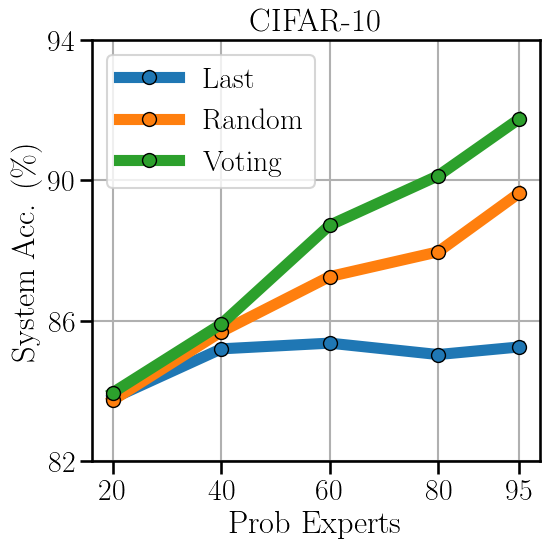

In [326]:
p_experts = [20, 40, 60, 80, 95]

sys_acc_last = np.array([method_d["system_accuracy"] for method_d in method_dict["last"]])
sys_acc_random = np.array([method_d["system_accuracy"] for method_d in method_dict["random"]])
sys_acc_voting = np.array([method_d["system_accuracy"] for method_d in method_dict["voting"]])

f, ax = plt.subplots(1, 1, figsize=fig_size)
ax.plot(p_experts, sys_acc_last, label=r"Last", **plot_args)
ax.plot(p_experts, sys_acc_random, label=r"Random", **plot_args)
ax.plot(p_experts, sys_acc_voting, label=r"Voting", **plot_args)
plt.xticks(p_experts, p_experts)
plt.yticks(list(plt.yticks()[0])[::2])
plt.ylabel(r'System Acc. ($\%$)')
plt.xlabel(r'Prob Experts')
plt.title(r"CIFAR-10")
plt.legend(loc="best")
plt.grid()
f.set_tight_layout(True)
plt.legend()
